<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/AAA_scenario_10yr_put.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Sep 17 20:26:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip3 install torch torchvision --upgrade

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.2.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [3]:
import torch
from torch.autograd import grad
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.2.0
cuda


##Scenario generator
The following block generate the US Diversified equity scenario. It follows the logic from 
Academy's Interest Rate Generator version 7.1.201805 which is download from [Society of Acturies](https://www.soa.org/resources/tables-calcs-tools/research-scenario/)


In [0]:
import math
@torch.jit.script
def aaa_us(N:int=10000, T:int=360, sigma_0:float=0.1476, device:str="cuda"):

  """
    return us equity scenario, following the AAA logic
    N is scenario number, 
    T is the number of month
    sigma_0 is the initial vol, default to AAA US Diversified Equity
    All other parameters below are for US Diversified Equity and
    copied from Academy's Interest Rate Generator (AIRG) (Version 7.1.201805)
  """


  tau = 0.12515
  phi = 0.35229
  sigma_v =0.32645
  rho = -0.2488
  A = 0.055
  B = 0.56
  C = -0.9
  
  sigma_min = 0.0305
  sigma_max = 0.3
  sigma_max2 = 0.7988


  #cholesky decompsition
  corr=torch.eye(2,device=device)
  corr[0,1]=rho
  corr[1,0]=rho
  chl=torch.cholesky(corr)

  #correlated random number
  rdn=torch.randn(N,T,2,1,device=device)
  rdn=torch.matmul(chl,rdn)
  rdn=rdn.view(N,T,2)

  sigma=torch.ones(N,T+1,device=device)
  us=torch.ones(N,T+1,device=device)

  sigma[:,0]=sigma_0
  us[:,0]=1.0

  log_tau=math.log(tau)
  log_sigma_min=math.log(sigma_min)
  log_sigma_max=math.log(sigma_max)
  log_sigma_max2=math.log(sigma_max2)

  sqrt12=math.sqrt(12.0)
  for t in range(T):
    log_vol=torch.log(sigma[:,t])
    log_vol=(1-phi)*log_vol+phi*log_tau
    log_vol=torch.clamp(log_vol,max=log_sigma_max)
    log_vol=log_vol+rdn[:,t,0]*sigma_v
    log_vol=torch.clamp(log_vol,min=log_sigma_min,max=log_sigma_max2)
    sigma[:,t+1]=torch.exp(log_vol)
    mean_return=A+B*sigma[:,t+1]+C*sigma[:,t+1]*sigma[:,t+1]
    next_return=mean_return/12.0+rdn[:,t,1]*sigma[:,t+1]/sqrt12
    us[:,t+1]=us[:,t]*torch.exp(next_return)
  return us, sigma

10 year point from excel 
avg ln=0.732818079,std ln=0.479882024
tensor(0.7276, device='cuda:0') tensor(0.4758, device='cuda:0')
30 year point from excel 
avg ln=2.196974867,std ln=0.825873276
tensor(2.1800, device='cuda:0') tensor(0.8257, device='cuda:0')


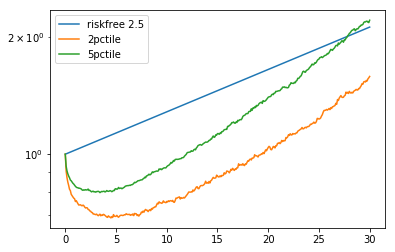

In [5]:
us, sigma = aaa_us()
log120=torch.log(us[:,120])
log360=torch.log(us[:,360])
print("10 year point from excel \navg ln=0.732818079,std ln=0.479882024")
print(log120.mean(),log120.std())
print("30 year point from excel \navg ln=2.196974867,std ln=0.825873276")
print(log360.mean(),log360.std())

import matplotlib.pyplot as plt
import numpy as np
us=us.to('cpu').numpy()
pct2=np.percentile(us,2,axis=0)
pct5=np.percentile(us,5,axis=0)
t2=torch.linspace(0,30,361).cpu().numpy()
rf2=np.exp(.025*t2)
plt.plot(t2,rf2,label='riskfree 2.5')
plt.plot(t2,pct2,label='2pctile')
plt.plot(t2,pct5,label='5pctile')
plt.yscale('log')
plt.legend()
plt.show()


In [0]:
def cashflow_1(scenario):
  """
    cash flow module for a put
  """
  strike = 1.5
  payout = torch.clamp(strike-scenario[:,-1],min=0.0)
  cf=torch.zeros_like(scenario)
  cf[:,-1].add_(payout)
  return cf


In [0]:
K1, K2 = 6, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

T=120
rf=0.025

idx,sigma=aaa_us(N=N1*N2,T=T)

cf=cashflow_1(idx)

idx=idx.view(N1,N2,T+1)
sigma=sigma.view(N1,N2,T+1)
cf=cf.view(N1,N2,T+1)

t=torch.linspace(0,T/12,T+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)

pv_payout=cf[:,:,-1]*disc[:,:,-1]

#the chg is discounted to time zero already
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]

# chg2 is the second order discounted to time zero    
chg2=torch.log(idx[:,:,1:]/idx[:,:,:-1])**2-((sigma[:,:,1:])**2)/12
chg2=chg2*disc[:,:,1:]

In [0]:
t=torch.linspace(T/12,1/12,T,device=device)  #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,T,1)
s.requires_grad=True
v=sigma[:,:,:-1].view(N1,N2,T,1)
t=t.view(N1,N2,T,1)
tsv=torch.cat((t,s,v),3)

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(3, 32),
    torch.nn.Tanh(),
    torch.nn.Linear(32,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)

In [10]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.02,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for t in range(50):
    for i in range(N1):
        optimizer.zero_grad()
        tsvi=tsv[i]
        delta=-model_delta(tsvi)

        g = torch.ones_like(delta)
        gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

        delta=delta.view(N2,T)
        gamma=gamma[:,:,1].view(N2,T)
        delta_gl=torch.sum(delta*chg[i],dim=1)
        gamma_gl=torch.sum(gamma*chg2[i],dim=1)

        hedged_price=pv_payout[i]-delta_gl-gamma_gl
      
        loss=hedged_price.var()
        loss.backward()
        optimizer.step()    
    if t%10==0: print(t,loss.item())
t2=time.time()
print(t2-t1)

0 0.0033262204378843307
10 0.0006632916629314423
20 0.0006646933034062386
30 0.0006109887617640197
40 0.0006070437375456095
61.18718957901001


In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

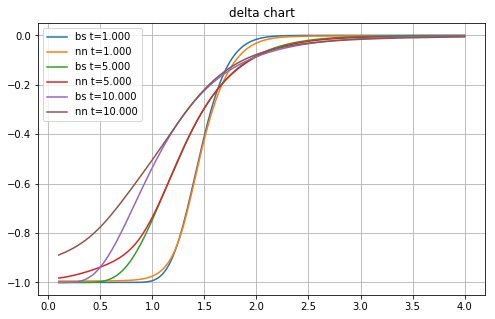

In [12]:
import matplotlib.pyplot as plt
import numpy as np

vol=torch.log(idx[:,:,-1]).std().cpu().item()
vol=vol/math.sqrt(10) 
#this is the effective volatility of the scenario at year 10

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[1,5.0,10.0]
for t in tl:
  s=torch.linspace(0.1,4,200,device=device)
  tsvc=torch.zeros((200,3),device=device)
  tsvc[:,0]=t
  tsvc[:,1]=s
  tsvc[:,2]= 0.1476
  d_bs=delta_bs(s.cpu().numpy(),1.5,rf,0,t,vol)-1
  d_nn=-model_delta(tsvc)
  plt.plot(s.cpu().numpy(),d_bs,label="bs t="+ "%.3f" % t)
  plt.plot(s.cpu().numpy(),d_nn.cpu().view(200).detach().numpy(),
           label="nn t="+ "%.3f" % t)



plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()